
CLIMATE POLICY SCENARIOS
Dirty Extreme: Minimal abatement, higher damages, modest short-term growth advantage
Baseline: Moderate abatement; standard growth/damage parameters
Carbon Tax: Price on carbon: faster decarbonization with moderate abatement cost
Cap-and-Trade: Market-based cap & trade: flexible compliance, slightly lower cost than tax
Tech Investment: R&D/subsidies: small upfront productivity hit, stronger long-run TFP growth
Green Subsidies: Moderate subsidies: lower abatement costs and modest growth boost
Regulatory Mandates: Forced performance standards: high mandatory abatement and a growth penalty
Adaptation & Resilience: Invest in resilience: reduces damages quickly with moderate recurring cost
Carbon Removal: Reforestation + DAC: improves sequestration but is costly and physically limited
International Climate Finance: Access to finance & tech transfer: lowers domestic cost burden, boosts initial productivity and long-run growth potential
Hybrid Green Growth: Tech + po

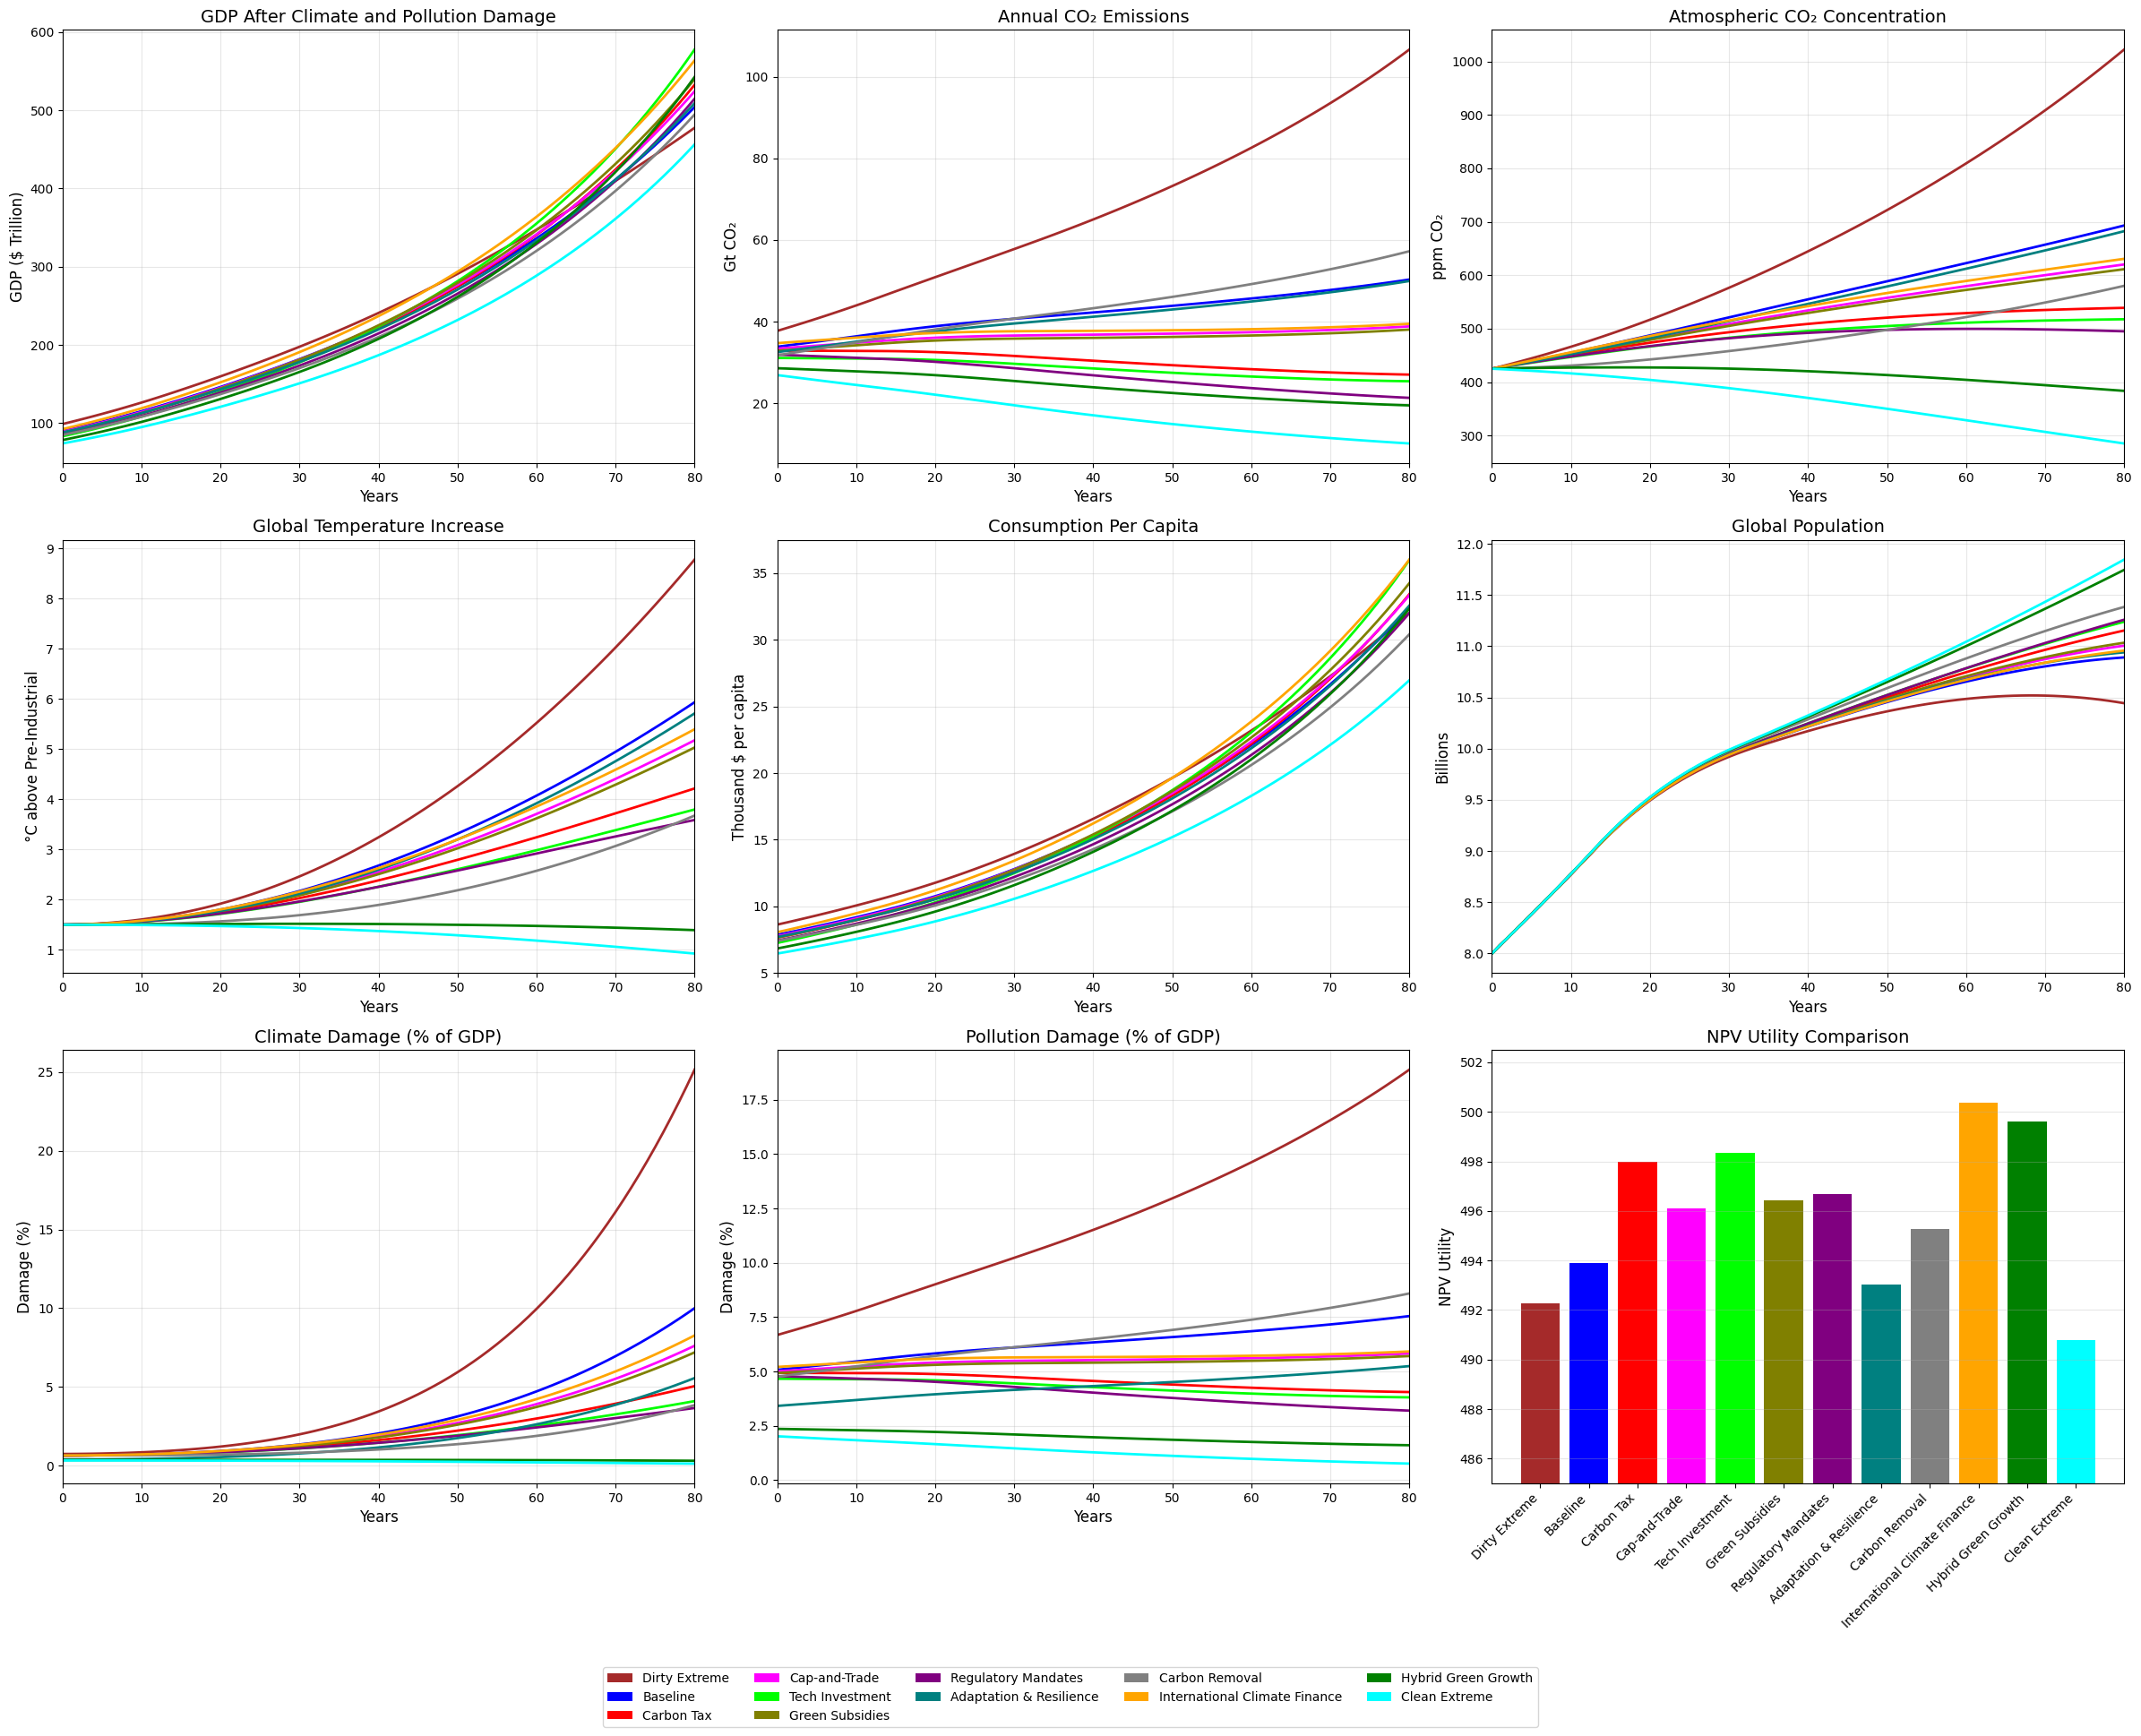


CLIMATE POLICY EFFECTIVENESS COMPARISON (YEAR 80 RESULTS)
                       Policy NPV Utility (80 yr) NPV Utility (150 yr) NPV GDP (80 yr) NPV GDP (150 yr) Final GDP ($T) Final GDP PC ($K) Final Temp (°C) Cumulative Emissions (Gt) GDP Growth (%) Final Consumption PC ($k) Climate Damage (%) Pollution Damage (%) Final Population (B) Pop Growth (%)
                Dirty Extreme                 446                  492           5,936            7,775          477.6              45.7            8.78                     5,457          384.3                      32.0               25.2                 18.9                10.44           30.5
                     Baseline                 440                  494           5,570            8,156          504.1              46.3            5.93                     3,417          460.9                      32.4               10.0                  7.5                10.89           36.1
                   Carbon Tax                 440    

In [3]:
# Multifaceted Environmental Development Model
# ======================================================================
# This model simulates the interaction between economic growth, climate change,
# and environmental policies over an 80-year period. It features:
# - Solow economic growth model with capital accumulation
# - Endogenous population dynamics affected by development and pollution
# - Carbon cycle and temperature physics
# - Climate and pollution damage functions
# - Three policy scenarios (baseline, clean, dirty)

# === Variable CATALOGUE (PARAMETER DEFINITIONS) ===
# α = alpha       # Capital share of income in production (Cobb–Douglas)
# σ = sigma       # Emissions intensity (Gt CO₂ per $ trillion GDP)
# δm = delta_m    # Natural sequestration rate of atmospheric CO₂
# δk = delta_k    # Capital depreciation rate
# ξ = xi          # Fraction of emissions that enter the atmosphere
# φ = phi         # Coefficient for pollution damage function on GDP
# φ_exp = phi_exp # Exponent for pollution damage sensitivity
# λ = lambda_     # Climate sensitivity parameter (response of temperature to forcing)
# γ = gamma       # Heat absorption (damping) parameter
# ψ1 = psi1       # Linear temperature damage coefficient (not used in current setup)
# ψ2 = psi2       # Quadratic temperature damage coefficient
# χ = chi         # Radiative forcing coefficient (Myhre et al. 1998)
# ρ = rho         # Pure rate of social time preference (discounting factor for utility)
# κ = kappa       # Cost intensity for policies
# ω = omega       # Population weight in utility function
# η = eta         # Elasticity of marginal utility
# θ = theta       # Abatement cost intensity parameter (fraction of GDP lost due to abatement)
# s = non-Greek   # Savings (investment) rate

# === TABLE OF CONTENTS ===
# 1. IMPORT PACKAGES
# 2. SIMULATION SETTINGS
# 3. ECONOMIC GROWTH PARAMETERS (SOLOW MODEL)
# 4. POLICY CONFIGURATION
# 5. EMISSIONS PARAMETERS
# 6. ATMOSPHERIC CARBON PARAMETERS
# 7. TEMPERATURE PARAMETERS
# 8. POPULATION GROWTH PARAMETERS
# 9. DAMAGE FUNCTIONS & UTILITY PARAMETERS
# 10. SIMULATION FUNCTION
# 11. KEY METRIC COMPARISONS (9 GRAPHS)
# 12. POLICY EFFECTIVENESS ANALYSIS
# 13. POLICY DETAILED RESULTS

# === 1. IMPORT PACKAGES ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 2. SIMULATION SETTINGS ===
T = 150  # Simulation duration (years)
years = list(range(T + 1))  # Time vector
display_years = 80  # Years to show in graphs/tables

# === 3. ECONOMIC GROWTH PARAMETERS (SOLOW MODEL) ===
# 3.1 Initial Economic Conditions
Y0 = 100           # Initial GDP ($ trillion)
L0 = 1.0           # Normalized model population
L_pop0 = 8         # Actual population (billions)
y0 = Y0/L_pop0     # Initial GDP per capita

# 3.2 Total Factor Productivity (TFP)
A0 = 1.0           # Initial TFP (baseline)

# 3.3 Production Parameters
α = 0.40           # Capital share (Cobb-Douglas)
K0 = (Y0 / (A0 * L0**(1-α))) ** (1/α)  # Initial capital stock
θ = 0.35           # Abatement cost intensity

# 3.4 Growth Parameters
δk = 0.025         # Capital depreciation rate (2.5%/yr)
s = 0.30           # Savings rate (30% of GDP)
g_A = 0.03         # Baseline TFP growth (3%/yr)

# === 4. POLICY CONFIGURATION ===
# Cost coefficients for non-abatement measures
κ_adapt = 0.08   # Cost intensity for damage reduction (adaptation/resilience)
κ_seq = 0.10     # Cost intensity for enhanced sequestration
κ_tech = 0.06    # Cost intensity for technology improvements
κ_intensity = 0.05  # Cost for reducing emissions intensity

class Policy:
    def __init__(self, name, color,
                 muVec=None,
                 theta=θ,
                 A0_multiplier=1.0,
                 g_A_multiplier=1.0,
                 σ_decay_rate=0.016,
                 ψ2_multiplier=1.0,
                 φ_multiplier=1.0,
                 δm_multiplier=1.0,
                 description=""):
        # Add constraints to prevent extreme parameters
        self.δm_multiplier = min(δm_multiplier, 1.8)  # Cap sequestration enhancement
        self.σ_decay_rate = min(σ_decay_rate, 0.03)   # Cap decarbonization rate
        self.name = name
        self.color = color
        self.description = description
        self.muVec = muVec if muVec is not None else np.linspace(0.0, 0.25, T + 1)
        self.theta = theta
        self.A0_multiplier = A0_multiplier
        self.g_A_multiplier = g_A_multiplier
        self.σ_decay_rate = σ_decay_rate
        self.ψ2_multiplier = ψ2_multiplier
        self.φ_multiplier = φ_multiplier
        self.δm_multiplier = δm_multiplier

        # Calculate non-abatement costs based on policy parameters
        # Cost for damage reduction (adaptation/resilience)
        self.adaptation_cost = κ_adapt * (1 - min(ψ2_multiplier, φ_multiplier))

        # Cost for enhanced sequestration
        self.sequestration_cost = κ_seq * (δm_multiplier - 1) if δm_multiplier > 1 else 0

        # Cost for technology improvements
        self.tech_cost = κ_tech * (1 - A0_multiplier) if A0_multiplier < 1 else 0

        # NEW: Cost for reducing emissions intensity
        self.intensity_cost = κ_intensity * σ_decay_rate / 0.016  # Normalized to baseline

        # Total non-abatement cost
        self.non_abatement_cost = (self.adaptation_cost +
                                  self.sequestration_cost +
                                  self.tech_cost +
                                  self.intensity_cost)

    def σ_func(self, t):
        return σ0 * (1 - self.σ_decay_rate) ** t

# Define policy scenarios
policies = [
    # Dirty extreme (negative externalities but higher short-term growth)
    Policy("Dirty Extreme", "brown",
           muVec=np.linspace(0.0, 0.05, T+1), σ_decay_rate=0.01, theta=0.28,
           A0_multiplier=1.08, g_A_multiplier=1.02,
           ψ2_multiplier=1.15, φ_multiplier=1.18,
           description="Minimal abatement, higher damages, modest short-term growth advantage"),

    # Baseline
    Policy("Baseline", "blue",
           muVec=np.linspace(0.0, 0.25, T+1), σ_decay_rate=0.016, theta=0.35,
           A0_multiplier=1.00, g_A_multiplier=1.00,
           description="Moderate abatement; standard growth/damage parameters"),

    # Carbon Tax (pricing)
    Policy("Carbon Tax", "red",
           muVec=np.linspace(0.0, 0.30, T+1), σ_decay_rate=0.023, theta=0.37,
           A0_multiplier=0.995, g_A_multiplier=1.00,
           description="Price on carbon: faster decarbonization with moderate abatement cost"),

    # Cap-and-Trade (market)
    Policy("Cap-and-Trade", "magenta",
           muVec=np.linspace(0.0, 0.28, T+1), σ_decay_rate=0.019, theta=0.32,
           A0_multiplier=0.997, g_A_multiplier=1.005,
           description="Market-based cap & trade: flexible compliance, slightly lower cost than tax"),

    # Tech Investment (R&D & subsidies)
    Policy("Tech Investment", "lime",
           muVec=np.linspace(0.0, 0.25, T+1), σ_decay_rate=0.025, theta=0.4,
           A0_multiplier=0.95, g_A_multiplier=1.05,
           description="R&D/subsidies: small upfront productivity hit, stronger long-run TFP growth"),

    # Green Subsidies (less extreme than Tech Investment)
    Policy("Green Subsidies", "olive",
           muVec=np.linspace(0.0, 0.22, T+1), σ_decay_rate=0.020, theta=0.30,
           A0_multiplier=0.985, g_A_multiplier=1.02,
           description="Moderate subsidies: lower abatement costs and modest growth boost"),

    # Regulatory Mandates (strict standards)
    Policy("Regulatory Mandates", "purple",
           muVec=np.linspace(0.0, 0.45, T+1), σ_decay_rate=0.024, theta=0.41,
           A0_multiplier=0.97, g_A_multiplier=0.995,
           description="Forced performance standards: high mandatory abatement and a growth penalty"),

    # Adaptation & Resilience
    Policy("Adaptation & Resilience", "teal",
           muVec=np.linspace(0.0, 0.18, T+1), σ_decay_rate=0.016, theta=0.34,
           A0_multiplier=0.995, g_A_multiplier=0.995,
           ψ2_multiplier=0.6, φ_multiplier=0.7,
           description="Invest in resilience: reduces damages quickly with moderate recurring cost"),

    # Carbon Removal & Enhanced Sinks
    Policy("Carbon Removal", "gray",
           muVec=np.linspace(0.0, 0.20, T+1), σ_decay_rate=0.014, theta=0.36,
           A0_multiplier=0.985, g_A_multiplier=0.99,
           δm_multiplier=1.5,
           description="Reforestation + DAC: improves sequestration but is costly and physically limited"),

    # International Climate Finance / Tech Transfer
    Policy("International Climate Finance", "orange",
           muVec=np.linspace(0.0, 0.25, T+1), σ_decay_rate=0.020, theta=0.30,
           A0_multiplier=1.04, g_A_multiplier=1.02,
           ψ2_multiplier=1.00, φ_multiplier=1.00, δm_multiplier=1.00,
           description="Access to finance & tech transfer: lowers domestic cost burden, boosts initial productivity and long-run growth potential"),

    # Hybrid Green Growth (balanced integrated policy)
    Policy("Hybrid Green Growth", "green",
           muVec=np.linspace(0.0, 0.35, T+1), σ_decay_rate=0.026, theta=0.38,
           A0_multiplier=0.95, g_A_multiplier=1.03,
           ψ2_multiplier=0.55, φ_multiplier=0.55, δm_multiplier=1.35,
           description="Tech + policy + adaptation mix: moderate upfront cost, strong long-run gains"),

    # Clean extreme (strongest mitigation & sinks; expensive)
    Policy("Clean Extreme", "cyan",
           muVec=np.linspace(0.0, 0.55, T+1), σ_decay_rate=0.030, theta=0.42,
           A0_multiplier=0.93, g_A_multiplier=0.99,
           ψ2_multiplier=0.5, φ_multiplier=0.5, δm_multiplier=1.5,
           description="Ambitious maximal abatement + sinks + resilience: highest costs, largest long-term damage reduction")
]


# Print policy descriptions
print("\n" + "="*50)
print("CLIMATE POLICY SCENARIOS")
print("="*50)
for policy in policies:
    print(f"{policy.name}: {policy.description}")
print("="*50 + "\n")

# === 5. EMISSIONS PARAMETERS ===
# 5.1 Emissions Intensity
σ0 = 0.356          # Initial emissions intensity (GtCO₂/$trillion GDP)

# === 6. ATMOSPHERIC CARBON PARAMETERS ===
C0 = 425            # Initial CO₂ concentration (ppm)
δm = 0.01           # Natural sequestration rate (1%/yr)
ξ = 0.45            # Atmospheric fraction (45%)
GT_TO_PPM = 1 / 2.13  # Conversion: GtCO₂ to ppm (2.13 GtCO₂ = 1 ppm)

# === 7. TEMPERATURE PARAMETERS ===
T0 = 1.5            # Initial temperature above pre-industrial levels (°C)
χ = 5.35            # Radiative forcing coefficient (W/m²)
λ_warm = 0.04       # Climate sensitivity for warming (°C per W/m²)
λ_cool = 0.015      # Reduced climate sensitivity for cooling (°C per W/m²)
γ_warm = 0.004      # Heat absorption coefficient for warming
γ_cool = 0.0015     # Reduced heat absorption for cooling
MIN_TEMP = 0.0      # Set minimum to 0°C (no cooling below pre-industrial)
MIN_CO2 = 280       # Increased minimum CO2 (closer to pre-industrial levels)
COOLING_RESISTANCE_FACTOR = 8.0  # Increased resistance factor

# === 8. POPULATION GROWTH PARAMETERS ===
# 8.1 Growth Rate Bounds
n_max = 0.012       # Maximum growth rate (1.2%/yr)
n_min = -0.01       # Minimum growth rate (-1%/yr)

# 8.2 Development Threshold
y_threshold = 15.0  # GDP/capita for demographic transition ($15k)

# 8.3 Impact Coefficients
γ_pop = 0.4                 # Development sensitivity
pollution_elasticity = 0.45  # Pollution impact on growth
climate_elasticity = 0.15    # Climate impact on growth

# 8.4 Population Limit Parameters
pop_limit = 10.0            # Population limit (billion)
pop_limit_penalty = 0.65    # Growth reduction when above limit (65%)
pop_limit_start = 9.0       # Soft limit start (billion)

# 8.5 Population Growth Function
def population_growth(y_pc, E, T_anomaly, t, current_pop, E0_policy):
    """
    Endogenous population growth with consistent units
        y_pc: GDP per capita (thousand dollars)
        E: Emissions (GtCO₂)
        T_anomaly: Temperature anomaly (°C)
        t: Time period
        current_pop: Current population (billions)
        E0_policy: Policy-specific initial emissions
    """
    # Logistic development factor
    development_factor = 1 / (1 + np.exp(γ_pop * (-y_pc - y_threshold)))

    # Base growth rate
    n_base = n_min + (n_max - n_min) * development_factor

    # Pollution impact (relative to initial emissions)
    pollution_impact = 1 - pollution_elasticity * (E/E0_policy)

    # Climate impact
    climate_impact = 1 - climate_elasticity * T_anomaly

    # Effective growth rate
    effective_growth = n_base * pollution_impact * climate_impact

    # Exogenous population limit effect
    if current_pop > pop_limit_start:
        exceed_factor = min(1.0, (current_pop - pop_limit_start) / (pop_limit - pop_limit_start))
        effective_growth *= (1 - pop_limit_penalty * exceed_factor)

    return np.clip(effective_growth, n_min, n_max)

# === 9. DAMAGE FUNCTIONS & UTILITY PARAMETERS ===
# 9.1 Climate Damage Parameters
ψ1 = 0.0          # Linear damage coefficient (disabled)
ψ2 = 0.00284      # Quadratic damage coefficient (DICE value)

# 9.2 Pollution Damage Parameters
φ = 0.0015        # Pollution damage coefficient
φ_exp = 1.0       # Damage exponent (linear)

# 9.3 Utility Parameters
ρ = 0.03          # Discount rate (3%/yr)
ω = 1.0           # Population weight
η = 1.45          # Elasticity of marginal utility

# === 10. SIMULATION FUNCTION ===
def run_simulation(policy):
    # Initialize vectors
    results = {
        'AVec': np.zeros(T + 1),
        'KVec': np.zeros(T + 1),
        'YVec': np.zeros(T + 1),
        'LPopVec': np.zeros(T + 1),
        'EVec': np.zeros(T + 1),
        'CVec': np.zeros(T + 1),
        'TVec': np.zeros(T + 1),
        'Utility': np.zeros(T + 1),
        'D_climate': np.zeros(T + 1),
        'D_pollution': np.zeros(T + 1),
        'Consumption': np.zeros(T + 1),
        'Y_after_damage': np.zeros(T + 1),
        'LVec': np.zeros(T + 1),
        'NPV_GDP': np.zeros(T + 1),
        'Final_GDP_per_capita': np.zeros(T + 1),
        'Non_abatement_cost': np.zeros(T + 1),
    }

    # Initial conditions
    results['LVec'][0] = L0
    results['LPopVec'][0] = L_pop0
    A0_policy = A0 * policy.A0_multiplier
    results['AVec'][0] = A0_policy
    results['KVec'][0] = K0
    results['YVec'][0] = A0_policy * (results['KVec'][0]**α) * (L0**(1-α))
    results['EVec'][0] = (1 - policy.muVec[0]) * policy.σ_func(0) * results['YVec'][0]
    E0_policy = results['EVec'][0]  # Policy-specific initial emissions
    results['CVec'][0] = C0
    results['TVec'][0] = T0
    results['Non_abatement_cost'][0] = policy.non_abatement_cost * results['YVec'][0]

    # Main simulation loop
    for t in range(T):
        # Population growth
        y_pc = results['YVec'][t] / results['LPopVec'][t]
        n = population_growth(y_pc, results['EVec'][t], results['TVec'][t],
                             t, results['LPopVec'][t], E0_policy)
        if t == 0:
            n = 0.01  # Initial growth rate

        results['LVec'][t+1] = results['LVec'][t] * (1 + n)
        results['LPopVec'][t+1] = results['LPopVec'][t] * (1 + n)

        # TFP growth
        results['AVec'][t+1] = results['AVec'][t] * (1 + g_A * policy.g_A_multiplier)

        # Production before any costs
        Y_raw = results['AVec'][t] * (results['KVec'][t]**α) * (results['LVec'][t]**(1-α))

        # Abatement costs
        abatement_cost = policy.theta * (policy.muVec[t]**2)
        Y_after_abatement = Y_raw * (1 - abatement_cost)

        # Non-abatement costs (adaptation, sequestration, tech)
        results['Non_abatement_cost'][t] = policy.non_abatement_cost * Y_after_abatement
        Y_after_all_costs = Y_after_abatement * (1 - policy.non_abatement_cost)

        results['YVec'][t] = Y_after_all_costs

        # Capital accumulation
        investment = s * results['YVec'][t]
        results['KVec'][t+1] = (1 - δk) * results['KVec'][t] + investment

        # Emissions
        results['EVec'][t] = (1 - policy.muVec[t]) * policy.σ_func(t) * results['YVec'][t]

        # Carbon accumulation
        emissions_ppm = results['EVec'][t] * GT_TO_PPM
        δm_policy = δm * policy.δm_multiplier
        results['CVec'][t+1] = (1 - δm_policy) * results['CVec'][t] + ξ * emissions_ppm

        # Apply realistic CO₂ floor (keep this simple constraint)
        results['CVec'][t+1] = max(MIN_CO2, results['CVec'][t+1])

        # Radiative forcing
        F = χ * np.log(max(results['CVec'][t+1], 1e-10) / C0)

        # Base temperature change - use appropriate parameters based on warming/cooling
        if F > 0:  # Warming regime
            base_temp_change = λ_warm * (F - γ_warm * results['TVec'][t])
        else:      # Cooling regime
            base_temp_change = λ_cool * (F - γ_cool * results['TVec'][t])

        # Only apply additional cooling resistance if we're actually cooling AND below a threshold
        if base_temp_change < 0 and results['TVec'][t] < 1.5:  # Only apply when cooling and below 1.5°C
            # Enhanced cooling resistance with multiple factors
            # Factor 1: Distance from minimum temperature (0°C)
            temp_distance_factor = max(0.1, (results['TVec'][t] - MIN_TEMP) / 1.5)

            # Factor 2: Exponential resistance based on how far we are from pre-industrial
            exp_resistance = 1 / (1 + np.exp(-COOLING_RESISTANCE_FACTOR * (results['TVec'][t] - 0.5)))

            # Factor 3: Policy-specific resistance - clean policies face less resistance
            policy_resistance = 1.0
            if "Clean" in policy.name or "Green" in policy.name:
                policy_resistance = 0.7  # Clean policies can cool more effectively

            # Combine all resistance factors
            cooling_resistance = temp_distance_factor * exp_resistance * policy_resistance

            # Apply the combined resistance only to cooling
            temp_change = base_temp_change * cooling_resistance
        else:
            # For warming or when above threshold, use the base response
            temp_change = base_temp_change

        # Apply the temperature change
        results['TVec'][t+1] = results['TVec'][t] + temp_change

        # Apply strict temperature floor
        results['TVec'][t+1] = max(MIN_TEMP, results['TVec'][t+1])

    # Final year calculations
    Y_raw_final = results['AVec'][T] * (results['KVec'][T]**α) * (results['LVec'][T]**(1-α))
    abatement_cost_final = policy.theta * (policy.muVec[T]**2)
    Y_after_abatement_final = Y_raw_final * (1 - abatement_cost_final)
    results['Non_abatement_cost'][T] = policy.non_abatement_cost * Y_after_abatement_final
    results['YVec'][T] = Y_after_abatement_final * (1 - policy.non_abatement_cost)
    results['EVec'][T] = (1 - policy.muVec[T]) * policy.σ_func(T) * results['YVec'][T]
    results['Final_GDP_per_capita'] = (results['Y_after_damage'][display_years] /
                                  results['LPopVec'][display_years])

    # Damage and utility calculations
    ψ2_policy = ψ2 * policy.ψ2_multiplier
    φ_policy = φ * policy.φ_multiplier
    # Create discount factors for both 80 and 200 years
    discount_factors_80 = np.array([1/(1+ρ)**t for t in range(display_years+1)])
    discount_factors_200 = np.array([1/(1+ρ)**t for t in range(T+1)])

    for t in range(T+1):
        # Climate damage
        D_climate = ψ2_policy * results['TVec'][t]**2
        results['D_climate'][t] = D_climate

        # Pollution damage
        D_pollution = φ_policy * results['EVec'][t]**φ_exp
        results['D_pollution'][t] = D_pollution

        # Effective GDP
        results['Y_after_damage'][t] = results['YVec'][t] / (1 + D_climate + D_pollution)

        # Consumption
        results['Consumption'][t] = results['Y_after_damage'][t] * (1 - s)
        C_pc = results['Consumption'][t] / results['LPopVec'][t]

        # Utility
        if η == 1:
            results['Utility'][t] = results['LPopVec'][t] * np.log(C_pc)
        else:
            results['Utility'][t] = results['LPopVec'][t] * (C_pc**(1-η) - 1)/(1-η)

    # NPV Utility and GDP for both timeframes
    results['NPV_Utility_80'] = np.sum(results['Utility'][:display_years+1] * discount_factors_80)
    results['NPV_Utility_200'] = np.sum(results['Utility'] * discount_factors_200)
    results['NPV_GDP_80'] = np.sum(results['Y_after_damage'][:display_years+1] * discount_factors_80)
    results['NPV_GDP_200'] = np.sum(results['Y_after_damage'] * discount_factors_200)  # NEW: 200-year NPV GDP

    return results

# === RUN SIMULATIONS FOR ALL POLICIES ===
policy_results = {}
for policy in policies:
    policy_results[policy.name] = run_simulation(policy)

# === 11. KEY METRIC COMPARISONS ===
# Increase the overall figure size
plt.figure(figsize=(24, 20))

# Plot 1: GDP After Damage
plt.subplot(3, 3, 1)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], result['Y_after_damage'][:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("GDP After Climate and Pollution Damage", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("GDP ($ Trillion)", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 2: Emissions Comparison
plt.subplot(3, 3, 2)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], result['EVec'][:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Annual CO₂ Emissions", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Gt CO₂", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 3: Atmospheric CO₂
plt.subplot(3, 3, 3)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], result['CVec'][:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Atmospheric CO₂ Concentration", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("ppm CO₂", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 4: Temperature
plt.subplot(3, 3, 4)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], result['TVec'][:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Global Temperature Increase", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("°C above Pre-Industrial", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 5: Consumption Per Capita
plt.subplot(3, 3, 5)
for policy in policies:
    result = policy_results[policy.name]
    consumption_pc = [result['Consumption'][t] / result['LPopVec'][t]
                      for t in range(display_years+1)]
    plt.plot(years[:display_years+1], consumption_pc,
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Consumption Per Capita", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Thousand $ per capita", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 6: Population
plt.subplot(3, 3, 6)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], result['LPopVec'][:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Global Population", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Billions", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 7: Climate Damage
plt.subplot(3, 3, 7)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], (result['D_climate'] * 100)[:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Climate Damage (% of GDP)", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Damage (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 8: Pollution Damage
plt.subplot(3, 3, 8)
for policy in policies:
    result = policy_results[policy.name]
    plt.plot(years[:display_years+1], (result['D_pollution'] * 100)[:display_years+1],
             label=policy.name, color=policy.color, linewidth=2)
plt.title("Pollution Damage (% of GDP)", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Damage (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 9: NPV Utility Bar Chart
plt.subplot(3, 3, 9)
npv_utilities = [policy_results[p.name]['NPV_Utility_200'] for p in policies]
colors = [p.color for p in policies]
plt.bar([p.name for p in policies], npv_utilities, color=colors)
plt.title("NPV Utility Comparison", fontsize=14)
plt.ylabel("NPV Utility", fontsize=12)
plt.ylim(485, 502.5)  # Zoomed-in Y range
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch

# Create legend entries manually using the colors and names from your policies
legend_elements = [Patch(facecolor=p.color, label=p.name) for p in policies]
plt.figlegend(handles=legend_elements, loc='lower center', ncol=5,
              bbox_to_anchor=(0.5, -0.02), fontsize=10)  # Changed from 0.01 to -0.05 to lower it

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("all_policies_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# === 12. POLICY EFFECTIVENESS ANALYSIS ===
def calculate_growth_rate(final, initial):
    return ((final / initial) - 1) * 100

policy_table = []
for policy in policies:
    result = policy_results[policy.name]

    # Final year metrics (year 80)
    final_year = display_years
    final_temp = result['TVec'][final_year]
    cum_emissions = np.sum(result['EVec'][:final_year+1])
    final_gdp = result['Y_after_damage'][final_year]
    gdp_growth = calculate_growth_rate(final_gdp, result['Y_after_damage'][0])
    consumption_pc = result['Consumption'][final_year] / result['LPopVec'][final_year]
    climate_damage = result['D_climate'][final_year] * 100
    pollution_damage = result['D_pollution'][final_year] * 100
    final_population = result['LPopVec'][final_year]
    pop_growth = calculate_growth_rate(final_population, result['LPopVec'][0])
    npv_utility_80 = result['NPV_Utility_80']
    npv_utility_200 = result['NPV_Utility_200']
    npv_gdp_80 = result['NPV_GDP_80']  # Renamed from npv_gdp
    npv_gdp_200 = result['NPV_GDP_200']  # NEW: 200-year NPV GDP
    final_gdp_pc = final_gdp / final_population

    policy_table.append({
        'Policy': policy.name,
        'NPV Utility (80 yr)': f"{npv_utility_80:,.0f}",
        'NPV Utility (150 yr)': f"{npv_utility_200:,.0f}",
        'NPV GDP (80 yr)': f"{npv_gdp_80:,.0f}",
        'NPV GDP (150 yr)': f"{npv_gdp_200:,.0f}",
        'Final GDP ($T)': f"{final_gdp:,.1f}",
        'Final GDP PC ($K)': f"{final_gdp_pc:,.1f}",
        'Final Temp (°C)': f"{final_temp:.2f}",
        'Cumulative Emissions (Gt)': f"{cum_emissions:,.0f}",
        'GDP Growth (%)': f"{gdp_growth:.1f}",
        'Final Consumption PC ($k)': f"{consumption_pc:.1f}",
        'Climate Damage (%)': f"{climate_damage:.1f}",
        'Pollution Damage (%)': f"{pollution_damage:.1f}",
        'Final Population (B)': f"{final_population:.2f}",
        'Pop Growth (%)': f"{pop_growth:.1f}"
    })

policy_df = pd.DataFrame(policy_table)

print("\n" + "="*180)
print("CLIMATE POLICY EFFECTIVENESS COMPARISON (YEAR 80 RESULTS)")
print("="*180)
print(policy_df.to_string(index=False))
print("="*180)

# === 13. POLICY DETAILED RESULTS ===
def generate_detailed_results(policy_name):
    result = policy_results[policy_name]
    detailed_df = pd.DataFrame({
        'Year': years[:display_years+1],
        'Population (B)': result['LPopVec'][:display_years+1],
        'Pop Growth Rate (%)': [
            ((result['LPopVec'][i]/result['LPopVec'][i-1]-1)*100
            if i > 0 else 0) for i in range(display_years+1)
        ],
        'GDP ($T)': result['YVec'][:display_years+1],
        'GDP After Damage ($T)': result['Y_after_damage'][:display_years+1],
        'GDP PC ($K)': [result['Y_after_damage'][t] / result['LPopVec'][t]
                       for t in range(display_years+1)],
        'Emissions (Gt CO₂)': result['EVec'][:display_years+1],
        'CO₂ (ppm)': result['CVec'][:display_years+1],
        'Temp Increase (°C)': result['TVec'][:display_years+1],
        'Climate Damage (%)': (result['D_climate'] * 100)[:display_years+1],
        'Pollution Damage (%)': (result['D_pollution'] * 100)[:display_years+1],
        'Consumption PC ($K)': [
            result['Consumption'][t] / result['LPopVec'][t]
            for t in range(display_years+1)
        ]
    })
    return detailed_df

# Print detailed results for each policy
for policy in policies:
    print(f"\n{'='*150}")
    print(f"POLICY DETAILED RESULTS: {policy.name.upper()}")
    print(f"{'='*150}")
    policy_df = generate_detailed_results(policy.name)
    print(policy_df.to_string(float_format="%.2f", index=False))
    print(f"{'='*150}\n")

with pd.ExcelWriter("all_policy_results.xlsx") as writer:
    policy_df.to_excel(writer, sheet_name="Summary", index=False)
    for policy in policies:
        detailed_df = generate_detailed_results(policy.name)
        detailed_df.to_excel(writer, sheet_name=policy.name[:30], index=False)
